# Coug Data Visualization

In [1]:
# imports
import rosbags_converter as rc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from seatrac_enums import CST_E
from matplotlib.ticker import MaxNLocator
from scipy.stats import linregress

/home/claytonsmith/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "
/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.25.0
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# User Variables

ROSBAGS_DIR = "~/so_apr_18_bags"
SAVES_DIR = "converted_bags"

MISSION_KEYWORDS = ["5.5"]

VERBOSE=True

In [3]:
# Convert Rosbags
dataframes = rc.load_dataframes(SAVES_DIR, keywords=MISSION_KEYWORDS, verbose=True)
if len(dataframes)==0:
    print("converting rosbags")
    typestore = rc.generate_typestore("../../cougars-ros2/src")
    dataframes = rc.convert_rosbags(ROSBAGS_DIR, typestore, 
                                    keywords=MISSION_KEYWORDS,verbose=VERBOSE)
    rc.save_to_csv(dataframes, SAVES_DIR, verbose=VERBOSE)
    dataframes = rc.load_dataframes(SAVES_DIR, keywords=MISSION_KEYWORDS)

Loading /home/claytonsmith/Documents/cougUV/CoUGARs/cougars-base-station/postprocessing/converted_bags/coug3_bluey/converted__SO_5.5_multi-2025-04-04-20-54-41
Loading /home/claytonsmith/Documents/cougUV/CoUGARs/cougars-base-station/postprocessing/converted_bags/base_station/converted__SO_5.5_multi
Loading /home/claytonsmith/Documents/cougUV/CoUGARs/cougars-base-station/postprocessing/converted_bags/coug1/converted__so_5.5_multi-2025-04-18-16-42-57
Loading /home/claytonsmith/Documents/cougUV/CoUGARs/cougars-base-station/postprocessing/converted_bags/coug2/converted__SO_5.5_multi-2025-04-18-16-42-59


In [4]:
# display topics by rosbag
for path, topics in dataframes.items():
    print(f"{path}:\n\t{list(topics.keys())}")

coug3_bluey/converted__SO_5.5_multi-2025-04-04-20-54-41:
	['/coug3/dvl/data', '/coug3/modem_rec', '/coug3/dvl/position', '/coug3/modem_status', '/coug3/dvl/velocity', '/coug3/depth_data', '/coug3/dvl/dead_reckoning', '/coug3/modem_imu', '/coug3/pressure/data', '/tf', '/coug3/dvl/dr_global']
base_station/converted__SO_5.5_multi:
	['/modem_rec', '/modem_send', '/modem_status', '/modem_cmd_update']
coug1/converted__so_5.5_multi-2025-04-18-16-42-57:
	['/coug1/extended_fix', '/coug1/dvl/dr_global', '/coug1/modem_rec', '/coug1/controls/command', '/coug1/dvl/dead_reckoning', '/coug1/gps_odom', '/coug1/desired_heading', '/coug1/modem_status', '/coug1/modem_imu', '/coug1/leak/data', '/coug1/safety_status', '/coug1/controls/debug', '/coug1/fix', '/coug1/pressure/data', '/coug1/battery/data', '/coug1/depth_data', '/tf', '/coug1/dvl/position', '/coug1/kinematics/command', '/coug1/desired_speed', '/coug1/desired_depth']
coug2/converted__SO_5.5_multi-2025-04-18-16-42-59:
	['/coug2/desired_heading', 

In [5]:
# lists dataframes by topic. 
# Assumes all vehicles have only one loaded mission and different namespaces
# Check previous cell output to confirm this is the case
dfsByTopic = {}
for topic_dfs in dataframes.values(): dfsByTopic.update(topic_dfs)
print(list(dfsByTopic.keys()))

['/coug3/dvl/data', '/coug3/modem_rec', '/coug3/dvl/position', '/coug3/modem_status', '/coug3/dvl/velocity', '/coug3/depth_data', '/coug3/dvl/dead_reckoning', '/coug3/modem_imu', '/coug3/pressure/data', '/tf', '/coug3/dvl/dr_global', '/modem_rec', '/modem_send', '/modem_status', '/modem_cmd_update', '/coug1/extended_fix', '/coug1/dvl/dr_global', '/coug1/modem_rec', '/coug1/controls/command', '/coug1/dvl/dead_reckoning', '/coug1/gps_odom', '/coug1/desired_heading', '/coug1/modem_status', '/coug1/modem_imu', '/coug1/leak/data', '/coug1/safety_status', '/coug1/controls/debug', '/coug1/fix', '/coug1/pressure/data', '/coug1/battery/data', '/coug1/depth_data', '/coug1/dvl/position', '/coug1/kinematics/command', '/coug1/desired_speed', '/coug1/desired_depth', '/coug2/desired_heading', '/coug2/controls/command', '/coug2/controls/debug', '/coug2/fix', '/coug2/dvl/dr_global', '/coug2/dvl/position', '/coug2/leak/data', '/coug2/safety_status', '/coug2/depth_data', '/coug2/battery/data', '/coug2/pr

In [6]:
# Display a dataframe
print(f"DataFrame example: base station modem update")
sampleDf = dfsByTopic["/modem_cmd_update"]
print(sampleDf.iloc[:5])
print("...")

DataFrame example: base station modem update
   header.stamp.sec  header.stamp.nanosec  header.frame_id  msg_id  \
0        1745016163             501219787              NaN      96   
1        1745016167             500108708              NaN      96   
2        1745016169             866298331              NaN      99   
3        1745016171             503793194              NaN      96   
4        1745016175             498925765              NaN      96   

   command_status_code  target_id  
0                    0          2  
1                    0          3  
2                   52          3  
3                    0          1  
4                    0          2  
...


In [7]:
# convert ros timestamps to pandas timestamps

for df in dfsByTopic.values():
    if "header.stamp.sec" in df.columns: 
        df["timestamp"] = pd.to_datetime(
            df["header.stamp.sec"] * 1_000_000_000 
            + df["header.stamp.nanosec"], unit='ns'
        )

bst_timestamps = dfsByTopic["/modem_status"]["timestamp"]
print(f"basestation timeframe:\t{bst_timestamps.min()} --- {bst_timestamps.max()}")

basestation timeframe:	2025-04-18 22:42:43.255680539 --- 2025-04-18 22:44:36.028592480


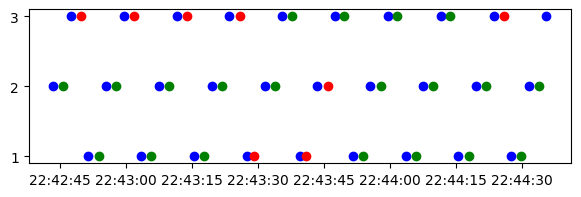

In [8]:
# Base station pings over time

bst_rec = dfsByTopic["/modem_rec"]
bst_cmd = dfsByTopic["/modem_cmd_update"]
bst_send = bst_cmd[bst_cmd["command_status_code"]==CST_E.CST_OK]
bst_err = bst_cmd[bst_cmd["command_status_code"]!=CST_E.CST_OK]

fig, ax = plt.subplots(figsize=(7, 2))
ax.plot(bst_send["timestamp"], bst_send["target_id"], 'bo')
ax.plot(bst_rec["timestamp"], bst_rec["src_id"], 'go')
ax.plot(bst_err["timestamp"], bst_err["target_id"], 'ro')
ax.yaxis.set_major_locator(MaxNLocator(integer=True))
plt.show()

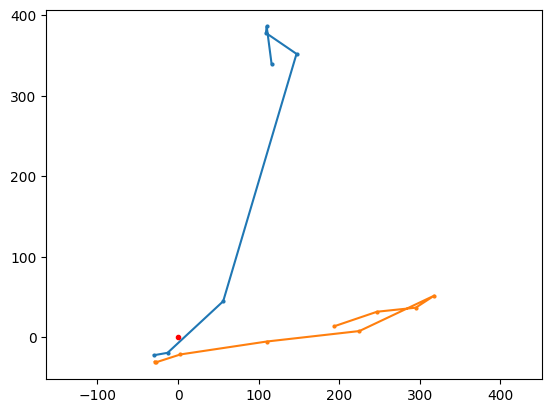

In [9]:
# Modem predicted paths relative to base station

for bid in range(15):
    modem_from_bid = bst_rec[bst_rec['src_id']==bid]
    if len(modem_from_bid)>0:
        plt.plot(modem_from_bid['position_easting'],
                 modem_from_bid['position_northing'], 
                 "-o", markersize=2)
plt.plot([0],[0],'ro',markersize=3)
plt.axis('equal')
plt.show()